In [1]:
import pandas as pd
import requests

In [2]:
df_citations = pd.read_csv('../../../data/uspatentcitation.tsv', delimiter='\t')

In [3]:
df_citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8798918 entries, 0 to 8798917
Data columns (total 9 columns):
uuid           object
patent_id      object
citation_id    object
date           object
name           object
kind           object
country        object
category       object
sequence       float64
dtypes: float64(1), object(8)
memory usage: 604.2+ MB


In [4]:
df_citations.head()

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
0,00000jd7thmiucpaol1hm1835,5354551,4875247,1989-10-01,Berg,NaN,US,NaN,11.0
1,00001005a7ti553pqlju1r2zo,9504742,4666886,1987-05-01,Baschang et al.,A,US,cited by applicant,5.0
2,00002ghv7v87txbmryocp9i60,D490798,D190749,1961-06-01,Matri et al.,S,US,cited by examiner,1.0
3,000034l12awrqow221x9q9jhl,8385913,7991644,2011-08-01,Bryant et al.,B2,US,cited by applicant,38.0
4,000041tx55fp5d0rqjofqfp5f,8695863,4683810,1987-08-01,Afimiwala,A,US,cited by examiner,3.0


In [5]:
df_edges = df_citations[['patent_id','citation_id']].head(500)
df_edges['patent_id'] = df_edges['patent_id'].str.strip()
df_edges['citation_id'] = df_edges['citation_id'].str.strip()
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
patent_id      500 non-null object
citation_id    500 non-null object
dtypes: object(2)
memory usage: 7.9+ KB


In [6]:
import networkx as nx
%matplotlib inline

G = nx.from_pandas_edgelist(df_edges, source='patent_id', target='citation_id')

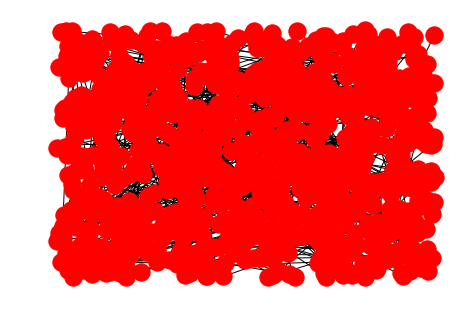

In [7]:
nx.draw_random(G)

In [8]:
nx.degree_histogram(G)

[0, 996, 2]

In [9]:
nx.density(G)

0.001005019065211667

## Some Algorithms...

In [10]:
from networkx.algorithms import approximation

k_components = approximation.k_components(G)

for i in k_components:
    print(len(k_components[i]))

498


## Patent Data Queries

### Put everything in a dataframe

In [ ]:
import math

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
df_patents = None

for i, chunk in enumerate(chunks(list(G), 25)):
    
    r = requests.post(
        'http://www.patentsview.org/api/patents/query',
        json={
            "q":{"patent_number": [str(num) for num in chunk] },
            "f":["patent_number", "patent_title", "assignee_id", "cpc_category", "nber_category_title"]
        }
    )
    info = r.json()

    if i==0:
        df_patents = pd.DataFrame(info['patents'])
        continue
    
    df_patents = df_patents.append(pd.DataFrame(info['patents']), ignore_index=True, verify_integrity=True)

df_patents.head(10)

In [21]:
df_patents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 5 columns):
assignees        902 non-null object
cpcs             902 non-null object
nbers            902 non-null object
patent_number    902 non-null object
patent_title     902 non-null object
dtypes: object(5)
memory usage: 35.3+ KB


### Add edge info to the nodes

In [18]:
for entry in df_patents.to_dict(orient='records'):
    try:
        G.nodes[entry['patent_number']].update({key: val for key, val in entry.items() if key != 'patent_number'})
    except KeyError:
        print("Couldn't find network entry for {}".format(entry['patent_number']))

In [19]:
G.nodes.data()

NodeDataView({'5354551': {'assignees': [{'assignee_id': 'b36beef84bf0154d36b00f40461a2dd1', 'assignee_key_id': '272709'}], 'cpcs': [{'cpc_category': 'inventional'}], 'patent_title': 'Oral and dental hygiene preparation', 'nbers': [{'nber_category_title': 'Drgs&Med'}]}, '4875247': {'assignees': [{'assignee_id': None, 'assignee_key_id': None}], 'cpcs': [{'cpc_category': 'additional'}, {'cpc_category': 'inventional'}], 'patent_title': 'Disposable tooth cleaning & polishing apparatus', 'nbers': [{'nber_category_title': 'Others'}]}, '9504742': {'assignees': [{'assignee_id': '9a620887749a7b642c41db2d6388f14b', 'assignee_key_id': '234814'}], 'cpcs': [{'cpc_category': 'inventional'}, {'cpc_category': 'additional'}], 'patent_title': 'Compositions for stimulation of mammalian innate immune resistance to pathogens', 'nbers': [{'nber_category_title': None}]}, '4666886': {'assignees': [{'assignee_id': 'd35e08011bccccdec085cf75f3f9e635', 'assignee_key_id': '321104'}], 'cpcs': [{'cpc_category': 'addi